In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

Functions

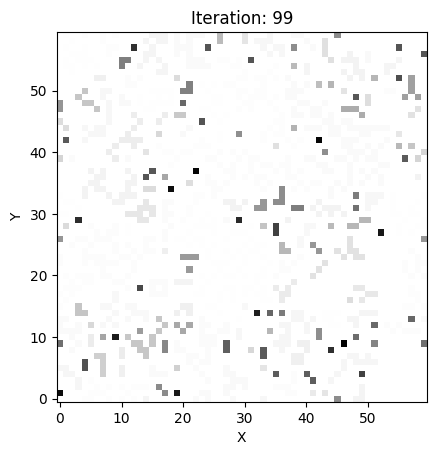

In [2]:
grid_size_x = 60
grid_size_y = 60
num_particles = 1200
num_iterations = 100

stop_criteria = False

def initialize_grid():
    grid = [[None] * grid_size_y for _ in range(grid_size_x)]
    for _ in range(num_particles):
        i = np.random.randint(grid_size_x)
        j = np.random.randint(grid_size_y)
        fitness = np.random.rand()
        particle = {'fitness': fitness}
        grid[i][j] = particle
    return grid

def mutate_fitness(grid, i, j):
    particle = grid[i][j]
    particle['fitness'] = np.random.rand()
    neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]  # von Neumann
    for neighbor_i, neighbor_j in neighbors:
        if 0 <= neighbor_i < grid_size_x and 0 <= neighbor_j < grid_size_y:
            neighbor_particle = grid[neighbor_i][neighbor_j]
            if neighbor_particle is not None:
                neighbor_particle['fitness'] = np.random.rand()

def rank_particles(grid):
    particles = []
    for i in range(grid_size_x):
        for j in range(grid_size_y):
            particle = grid[i][j]
            if particle is not None and particle != 'mark':
                particles.append(particle)
    particles.sort(key=lambda x: x['fitness'])
    return particles

def check_neighborhood(grid, i, j): #Moore neighborhood
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            neighbor_i = (i + dx) % grid_size_x
            neighbor_j = (j + dy) % grid_size_y
            neighbor_particle = grid[neighbor_i][neighbor_j]
            if neighbor_particle is not None or grid[neighbor_i][neighbor_j] == 'mark':
                neighbors.append((neighbor_i, neighbor_j))
    return neighbors

def move_to_free_cell(grid, i, j, neighbors):
    for neighbor_i, neighbor_j in neighbors:
        if grid[neighbor_i][neighbor_j] is None:
            grid[neighbor_i][neighbor_j] = grid[i, j]
            grid[i][j] = None
            return

def move_to_mark(grid, i, j, neighbors):
    current_fitness = grid[i][j]['fitness']
    best_fitness = float('inf')
    best_neighbor = None
    for neighbor_i, neighbor_j in neighbors:
        if grid[neighbor_i][neighbor_j] == 'mark':
            neighbor_fitness = grid[i][j]['fitness']
            if neighbor_fitness < best_fitness and neighbor_fitness < current_fitness:
                best_fitness = neighbor_fitness
                best_neighbor = (neighbor_i, neighbor_j)
    if best_neighbor is not None:
        grid[best_neighbor[0]][best_neighbor[1]] = grid[i][j]
        grid[i][j] = 'mark'

def leave_mark(grid, i, j):
    grid[i][j] = 'mark'

def erase_mark(grid, i, j):
    if grid[i][j] == 'mark':
        grid[i][j] = None


def migrate_species(grid):
    grid_copy = [row[:] for row in grid]
    grid_size = len(grid)
    for i in range(grid_size):
        for j in range(grid_size):
            if isinstance(grid[i][j], dict):
                particle = grid_copy[i][j]
                current_fitness = particle['fitness']
                neighbors = check_neighborhood(grid_copy, i, j)
                best_fitness = current_fitness
                best_neighbor = None
                for neighbor in neighbors:
                    neighbor_i, neighbor_j = neighbor
                    if isinstance(grid_copy[neighbor_i][neighbor_j], dict):
                        neighbor_fitness = grid_copy[neighbor_i][neighbor_j]['fitness']
                        if neighbor_fitness > best_fitness:
                            best_fitness = neighbor_fitness
                            best_neighbor = neighbor
                if best_neighbor is not None:
                    neighbor_i, neighbor_j = best_neighbor
                    grid[neighbor_i][neighbor_j] = grid_copy[i][j]
                    grid_copy[i][j] = None
    return grid


def apply_functions(grid, fitness_grid, iteration):
    migrate_species(grid)

    # updating fitness grid
    for i in range(grid_size_x):
        for j in range(grid_size_y):
            if grid[i][j] is not None:
                fitness_grid[i][j] = grid[i][j]['fitness']

    # apply mutate_fitness function
    i = np.random.randint(grid_size_x)
    j = np.random.randint(grid_size_y)
    mutate_fitness(grid, i, j)

    neighbors = check_neighborhood(grid, i, j)
    move_to_free_cell(grid, i, j, neighbors)

    action = np.random.choice(["move", "leave", "erase"])

    if action == "move":
        move_to_mark(grid, i, j, neighbors)
    elif action == "leave":
        leave_mark(grid, i, j)
    elif action == "erase":
        erase_mark(grid, i, j)
    
    # check stop criteria
    particles = rank_particles(grid)
    if particles[0]['fitness'] == particles[-1]['fitness']:
        stop_criteria = True

    return fitness_grid, stop_criteria


grid = initialize_grid()
fig, ax = plt.subplots()
fitness_grid = np.zeros((grid_size_x, grid_size_y))

def update_plot(iteration):
    global grid, stop_criteria
    migrate_species(grid)

    # updating fitness grid
    for i in range(grid_size_x):
        for j in range(grid_size_y):
            if grid[i][j] is not None:
                fitness_grid[i][j] = grid[i][j]['fitness']

    # clear axis before each plot
    ax.clear()

    im = ax.imshow(fitness_grid, cmap='Greys', vmin=0, vmax=1, origin='lower')
    ax.set_title(f"Iteration: {iteration}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # check stop criteria
    particles = rank_particles(grid)
    if particles[0]['fitness'] == particles[-1]['fitness']:
        stop_criteria = True


def animate(frame):
    update_plot(frame)
    if stop_criteria:
        anim.event_source.stop()  # Stop the animation if stop criteria met

anim = FuncAnimation(fig, animate, frames=num_iterations, interval=200, repeat=False)
anim.save("migration.gif", writer='pillow', fps=10)
plt.show()
